In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from numba import jit, prange, njit
from blimpy import Waterfall
import time
import random
from synthetic_real_dynamic_edit import create_true, create_full_cadence, create_false, create_true_single_shot, create_true_faster
import math
from sklearn.metrics import silhouette_score
import sys
sys.path.insert(1, '../ML_Training')
sys.path.insert(2, '../GBT_pipeline')
sys.path.insert(3, '../test_bench')
from preprocess_dynamic import get_data
from single_search import search_model_eval, combine
from skimage.transform import rescale, resize, downscale_local_mean
import gc
from data_generation import create_data_set
from sklearn.tree import DecisionTreeClassifier


gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10000)])
        tf.config.experimental.set_virtual_device_configuration(
            gpus[1],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10000)])
        tf.config.experimental.set_virtual_device_configuration(
            gpus[2],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=7000)])
        tf.config.experimental.set_virtual_device_configuration(
            gpus[3],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10000)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

/home/pma/.local/lib/python3.6/site-packages/numba/core/decorators.py:255: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/home/pma/.local/lib/python3.6/site-packages/numba/core/decorators.py:255: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


4 Physical GPUs, 4 Logical GPUs


In [2]:
NUM_SAMPLES = 3000
plate = np.load('../../../../../../../datax/scratch/pma/real_filtered_LARGE_HIP13402.npy')

print(plate.shape)

(14567, 6, 16, 4096)


In [3]:
index = 0
print(plate[index,0,:,:].max())
print(plate[index,1,:,:].max())
print(plate[index,2,:,:].max())
print(plate[index,3,:,:].max())
print(plate[index,4,:,:].max())

55783102349312.0
55941240193024.0
56078792392704.0
56248481349632.0
55656044298240.0


In [4]:
print(plate.shape)
data, false_data_train, true_data_train = create_data_set(plate, NUM_SAMPLES=NUM_SAMPLES, snr_base=20, snr_range = 50, factor=1)
del  data
gc.collect()

(14567, 6, 16, 4096)
Creating True
(3000, 6, 16, 4096)
(3000, 6, 16, 4096) (3000, 6, 16, 512)
(3000, 6, 16, 512)
(18000, 16, 512, 1)
Creating False
(18000, 6, 16, 4096) (18000, 6, 16, 512)
(18000, 6, 16, 512)
Creating True
(9000, 6, 16, 4096) (9000, 6, 16, 512)
(9000, 6, 16, 512)
(9000, 6, 16, 4096) (9000, 6, 16, 512)
(9000, 6, 16, 512)
(18000, 6, 16, 512, 1)


0

In [5]:
print(false_data_train[3, 0,:,:,0].max())
print(false_data_train[3, 4,:,:,0].max())

0.5989233238546738
0.5399698984212224


In [6]:
NUM_SAMPLES = 1000
plate_test = np.load('../../../../../../../datax/scratch/pma/real_filtered_LARGE_test_HIP15638.npy')
plate_test1 = np.load('../../../../../../../datax/scratch/pma/real_filtered_LARGE_test_11_HIP15638.npy')
plate_test = np.concatenate((plate_test,plate_test1))

In [7]:
print(plate_test.shape)
NUM_SAMPLES = 2000
data, false_data_test, true_data_test = create_data_set(plate_test, NUM_SAMPLES=NUM_SAMPLES, snr_base=20, snr_range = 50, factor=1)
del plate_test, data
gc.collect()

(19422, 6, 16, 4096)
Creating True
(2000, 6, 16, 4096)
(2000, 6, 16, 4096) (2000, 6, 16, 512)
(2000, 6, 16, 512)
(12000, 16, 512, 1)
Creating False
(12000, 6, 16, 4096) (12000, 6, 16, 512)
(12000, 6, 16, 512)
Creating True
(6000, 6, 16, 4096) (6000, 6, 16, 512)
(6000, 6, 16, 512)
(6000, 6, 16, 4096) (6000, 6, 16, 512)
(6000, 6, 16, 512)
(12000, 6, 16, 512, 1)


0

In [8]:
print("reshape")
true_data_train_unroll = np.reshape(true_data_train, (true_data_train.shape[0], true_data_train.shape[1]*true_data_train.shape[2]*true_data_train.shape[3]))
false_data_train_unroll = np.reshape(false_data_train, (false_data_train.shape[0], false_data_train.shape[1]*false_data_train.shape[2]*false_data_train.shape[3]))
print("reshape")
true_data_test_unroll = np.reshape(true_data_test, (true_data_test.shape[0], true_data_test.shape[1]*true_data_test.shape[2]*true_data_test.shape[3]))
false_data_test_unroll = np.reshape(false_data_test, (false_data_test.shape[0], false_data_test.shape[1]*false_data_test.shape[2]*false_data_test.shape[3]))

reshape
reshape


In [9]:
from sklearn.utils import shuffle
import numpy as np


train_unroll = np.concatenate((true_data_train_unroll,false_data_train_unroll))
print(train_unroll.shape)
true_labels = np.ones((true_data_train_unroll.shape[0]))

false_labels = np.zeros((false_data_train_unroll.shape[0]))
labels = np.concatenate((true_labels,false_labels))
print(labels.shape)
train_unroll, labels = shuffle(train_unroll, labels)

(36000, 49152)
(36000,)


In [10]:
test_unroll = np.concatenate((true_data_test_unroll,false_data_test_unroll))
print(test_unroll.shape)
true_test_labels = np.ones((true_data_test_unroll.shape[0]))

false_test_labels = np.zeros((false_data_test_unroll.shape[0]))
test_labels = np.concatenate((true_test_labels,false_test_labels))
print(test_labels.shape)
test_unroll, test_labels = shuffle(test_unroll, test_labels)

(24000, 49152)
(24000,)


In [11]:
print(test_unroll.shape)

(24000, 49152)


In [12]:
from sklearn.decomposition import PCA
pca = PCA(n_components=48)
smaller_train = pca.fit_transform(train_unroll)
smaller_test = pca.fit_transform(test_unroll)
print(smaller_train.shape)

(36000, 48)


# Random Forest Decision Tree

In [13]:
from sklearn.ensemble import RandomForestClassifier

# Create the model with 100 trees
tree = RandomForestClassifier(n_estimators=1000, 
                               bootstrap = True,
                               criterion='entropy',
                               max_depth=20,
                               max_features = 'sqrt',n_jobs=-1)
# Fit on training data
tree.fit(smaller_train, labels)

RandomForestClassifier(criterion='entropy', max_depth=20, max_features='sqrt',
                       n_estimators=1000, n_jobs=-1)

In [14]:
print(labels)

[1. 1. 0. ... 1. 1. 0.]


In [15]:
# Actual class predictions
print(smaller_test.shape)
rf_predictions = tree.predict(smaller_test)
# Probabilities for each class
rf_probs = tree.predict_proba(smaller_test)[:, 1]

(24000, 48)


In [16]:
from sklearn.metrics import roc_auc_score

# Calculate roc auc
roc_value = roc_auc_score(test_labels, tree.predict_proba(smaller_test)[:, 1])
print(roc_value)

0.7470841770833334


In [17]:
from sklearn.metrics import accuracy_score
accuracy_score(test_labels,  tree.predict(smaller_test))

0.7067916666666667

In [18]:
%matplotlib inline
from sklearn import metrics

fpr_tree, tpr_tree, _ = metrics.roc_curve(test_labels,  tree.predict_proba(smaller_test)[:, 1])
auc_rf= metrics.roc_auc_score(test_labels, tree.predict(smaller_test))
print(auc_rf)

0.7067916666666666


In [19]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(test_labels, tree.predict(smaller_test), average='binary')

(0.6408902515187646, 0.9406666666666667, 0.762367878972073, None)

# SVM


In [20]:
from sklearn import svm

SVM = svm.SVC()
SVM.fit(smaller_train, labels)

SVC()

In [21]:
probs = SVM.predict(smaller_test)

roc_value = roc_auc_score(test_labels, probs)
print(roc_value)

accuracy_score(test_labels, SVM.predict(smaller_test))

from sklearn import metrics

fpr_svm, tpr_svm, _ = metrics.roc_curve(test_labels,   SVM.predict(smaller_test))
auc_svm= metrics.roc_auc_score(test_labels, SVM.predict(smaller_test))
print(auc_svm)

0.7050833333333333
0.7050833333333333


In [22]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(test_labels, SVM.predict(smaller_test), average='binary')

(0.6406285714285714, 0.93425, 0.7600677966101694, None)

# Artifical Neural Network

In [23]:
from keras.models import Sequential
from keras.layers import Dense
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from numba import jit, prange, njit
from blimpy import Waterfall
import time
import random
import datetime
from synthetic_real_dynamic import create_true, create_full_cadence, create_false, create_true_single_shot, create_true_faster
from scipy import spatial
from numpy import dot
from numpy.linalg import norm
import math
from sklearn.metrics import silhouette_score
import sys
sys.path.insert(1, '../ML_Training')
sys.path.insert(2, '../GBT_pipeline')
from preprocess_dynamic import get_data
from single_search import search_model_eval, combine
from skimage.transform import rescale, resize, downscale_local_mean
import gc
from keras.regularizers import l1, l2
from data_generation import create_data_set

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10000)])
        tf.config.experimental.set_virtual_device_configuration(
            gpus[1],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10000)])
        tf.config.experimental.set_virtual_device_configuration(
            gpus[2],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=7000)])
        tf.config.experimental.set_virtual_device_configuration(
            gpus[3],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10000)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

4 Physical GPUs, 4 Logical GPUs


/home/pma/.local/lib/python3.6/site-packages/numba/core/decorators.py:255: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [24]:
from tensorflow.python.client import device_lib
gpus = tf.config.experimental.list_physical_devices('GPU')

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(smaller_train, labels, test_size=0.2)
print(X_train.shape)

(28800, 48)


In [26]:
model = Sequential()
model.add(Dense(512, input_dim=48, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.001), metrics=[tf.keras.metrics.AUC(),'accuracy'])
# fit the keras model on the dataset
model.summary()
model.fit(X_train, y_train, epochs=300, batch_size=2000, 
          validation_data=(X_test, y_test),validation_batch_size=1000)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               25088     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 3

In [27]:
model.fit(X_train, y_train, epochs=50, batch_size=2000, 
          validation_data=(X_test, y_test),validation_batch_size=1000)

Epoch 1/50
15/15 [==============================] - 0s 14ms/step - loss: 0.0814 - auc: 0.9954 - accuracy: 0.9624 - val_loss: 1.3887 - val_auc: 0.8265 - val_accuracy: 0.7731
Epoch 2/50
15/15 [==============================] - 0s 10ms/step - loss: 0.0797 - auc: 0.9958 - accuracy: 0.9644 - val_loss: 1.4783 - val_auc: 0.8221 - val_accuracy: 0.7721
Epoch 3/50
15/15 [==============================] - 0s 11ms/step - loss: 0.0876 - auc: 0.9947 - accuracy: 0.9594 - val_loss: 1.4038 - val_auc: 0.8263 - val_accuracy: 0.7740
Epoch 4/50
15/15 [==============================] - 0s 11ms/step - loss: 0.1283 - auc: 0.9896 - accuracy: 0.9481 - val_loss: 1.1417 - val_auc: 0.8349 - val_accuracy: 0.7722
Epoch 5/50
15/15 [==============================] - 0s 11ms/step - loss: 0.1103 - auc: 0.9922 - accuracy: 0.9517 - val_loss: 1.0572 - val_auc: 0.8432 - val_accuracy: 0.7765
Epoch 6/50
15/15 [==============================] - 0s 11ms/step - loss: 0.0874 - auc: 0.9952 - accuracy: 0.9613 - val_loss: 1.1587 - v

In [28]:
accuracy_score( test_labels, model.predict_classes(smaller_test))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


0.6277083333333333

In [29]:
roc_value = roc_auc_score( test_labels, model.predict(smaller_test))
print(roc_value)
from sklearn import metrics

fpr_ann, tpr_ann, _ = metrics.roc_curve(test_labels,   model.predict(smaller_test))
auc_ann = metrics.roc_auc_score(test_labels, model.predict(smaller_test))
print(auc_ann)

0.6930410798611111
0.6930410798611111


In [30]:
model.predict(smaller_test)[0]

array([0.43375444], dtype=float32)

In [31]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(test_labels, model.predict_classes(smaller_test), average='binary')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


(0.6267681363222765, 0.6314166666666666, 0.6290838141890489, None)

# 3-D Convolutional Neural Net

In [32]:
import tensorflow as tf
import keras
from keras.models import Sequential 
from keras.layers import Dense, Dropout
from keras.layers.core import Activation, Flatten
import matplotlib.pyplot as plt
from keras.optimizers import SGD,RMSprop
from keras.models import load_model
from keras.losses import binary_crossentropy
from keras.utils import np_utils
import os, os.path
import numpy as np
import tempfile
from keras.layers import Reshape
from keras import losses
from keras.layers.advanced_activations import LeakyReLU 
from keras.activations import sigmoid
from keras.layers import Input, LSTM, MaxPooling1D, Conv1D
from keras.models import Model
from keras import backend as K
from keras.layers.convolutional import Convolution1D
from keras.layers import  Conv2D, MaxPool3D, MaxPooling2D, TimeDistributed, Embedding, Convolution2D , Lambda
from keras.layers import BatchNormalization
from keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping, ModelCheckpoint
from blimpy import Waterfall
from keras.layers import Reshape, Conv2DTranspose, BatchNormalization, ZeroPadding2D
from keras.layers import Softmax
from  keras.backend import expand_dims
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from random import seed
from random import random
import time 
import datetime
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from scipy.stats import lognorm

from scipy import stats

In [33]:
from sklearn.utils import shuffle
import numpy as np


train = np.concatenate((true_data_train,false_data_train))
print(train.shape)
true_labels = np.ones((true_data_train.shape[0]))

false_labels = np.zeros((false_data_train.shape[0]))
labels = np.concatenate((true_labels,false_labels))
print(labels.shape)
train, labels = shuffle(train, labels)

(36000, 6, 16, 512, 1)
(36000,)


In [34]:
test = np.concatenate((true_data_test,false_data_test))
print(test.shape)
true_test_labels = np.ones((true_data_test.shape[0]))
true_labels[:]=1

false_test_labels = np.zeros((false_data_test.shape[0]))
false_test_labels[:]=0
test_labels = np.concatenate((true_test_labels,false_test_labels))
print(test_labels.shape)
test, test_labels = shuffle(test, test_labels)

(24000, 6, 16, 512, 1)
(24000,)


In [35]:
X_train, X_test, y_train, y_test = train_test_split(train, labels, test_size=0.2)
print(X_train.shape)

(28800, 6, 16, 512, 1)


In [36]:
def build_model():
    input_size = X_train.shape[1:]
    model = Sequential()
    
    model.add(Conv3D(16, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform',padding='same', 
                     input_shape=(6,16,512,1)))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(BatchNormalization(center=True, scale=True))
    model.add(Dropout(0.5))
    
    model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(BatchNormalization(center=True, scale=True))
    model.add(Dropout(0.5))
    
    model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization(center=True, scale=True))
    model.add(Dropout(0.5))
    

    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    # Compile the model
    model.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.Adam(lr=0.001),
                  metrics=[tf.keras.metrics.AUC(), 'accuracy'])
    model.summary()

    return model

In [37]:
strategy = tf.distribute.MirroredStrategy(
    cross_device_ops=tf.distribute.ReductionToOneDevice())
print("Number of devices: {}".format(strategy.num_replicas_in_sync))


with strategy.scope():
    model_conv = build_model()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
tensorflow      INFO     Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Number of devices: 4
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
tensorflow      INFO     Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
tensorflow      INFO     Reduce to /job:localhost/r

In [38]:
history = model_conv.fit(X_train, y_train,epochs=300, batch_size=1000, shuffle=True, 
                validation_data=(X_test, y_test)) 

Epoch 1/300
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3').
tensorflow      INFO     Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3').
tensorflow      INFO     Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:

In [39]:
from sklearn import metrics

fpr_cnn, tpr_cnn, _ = metrics.roc_curve(test_labels, model_conv.predict(test))
auc_conv = metrics.roc_auc_score(test_labels, model_conv.predict(test))
print(auc_conv)

0.9866376666666667


In [40]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(test_labels, model_conv.predict_classes(test), average='binary')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


(0.9988699500894623, 0.8839166666666667, 0.9378840797559573, None)

In [41]:
candidate_false = model_conv.predict(false_data_test)
candidate_true = model_conv.predict(true_data_test)

In [42]:
threshold = 0.5
count=0
for i in range(candidate_false.shape[0]):
    if candidate_false[i]<threshold:
        count+=1
print(count/candidate_false.shape[0])
count=0
for i in range(candidate_true.shape[0]):
    if candidate_true[i]>threshold:
        count+=1
print(count/candidate_true.shape[0])

0.999
0.8836666666666667


# 002 Algorithm

In [43]:
import joblib
from execute_model import model_load

model_name = "../test_bench/VAE-BLPC1-ENCODER_compressed_512v13-0"
zeroTwo = model_load(model_name+".h5")
# zeroTwo = model_load("../test_bench/VAE-BLPC1-ENCODER_compressed_512v13-0.h5")

forest = joblib.load('../test_bench/random_forest_1000_v4.joblib')

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
tensorflow      INFO     Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
tensorflow      WARNING  No training configuration found in the save file, so the model was *not* compiled. Compile it manually.


/home/pma/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.0 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/pma/.local/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.0 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [44]:
print(test.shape)

(24000, 6, 16, 512, 1)


In [45]:
frame_list = []
for i in range(test.shape[0]):
    print(i)
    frame_list.append(zeroTwo.predict(test[i,:,:,:,:])[2].ravel())
frame_list = np.array(frame_list)
probs_list = forest.predict_proba(frame_list)[:, 1]
print(probs_list)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [46]:
fpr_002, tpr_002, _ = metrics.roc_curve(test_labels,  probs_list)
auc_002= metrics.roc_auc_score(test_labels, probs_list)
print(auc_002)

0.9992102604166667


In [47]:
my_model_classes = []
for i in range(len(probs_list)):
    if probs_list[i]>0.5:
        my_model_classes.append(1)
    else:
        my_model_classes.append(0)

In [48]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(test_labels,my_model_classes, average='binary')

(0.9944374209860936, 0.98325, 0.9888120678818353, None)

In [49]:
#0.981
import csv
with open('auc_cnn.csv', 'w') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerows(zip(fpr_cnn,tpr_cnn))

In [50]:
print(tpr_cnn, tpr_cnn)

[0.         0.59291667 0.61658333 ... 0.99991667 1.         1.        ] [0.         0.59291667 0.61658333 ... 0.99991667 1.         1.        ]


In [51]:
import pandas as pd 

df = pd.read_csv('auc_cnn.csv')
fpr_cnn,tpr_cnn = df['0.0'],df['0.0.1']

# ROC Curves

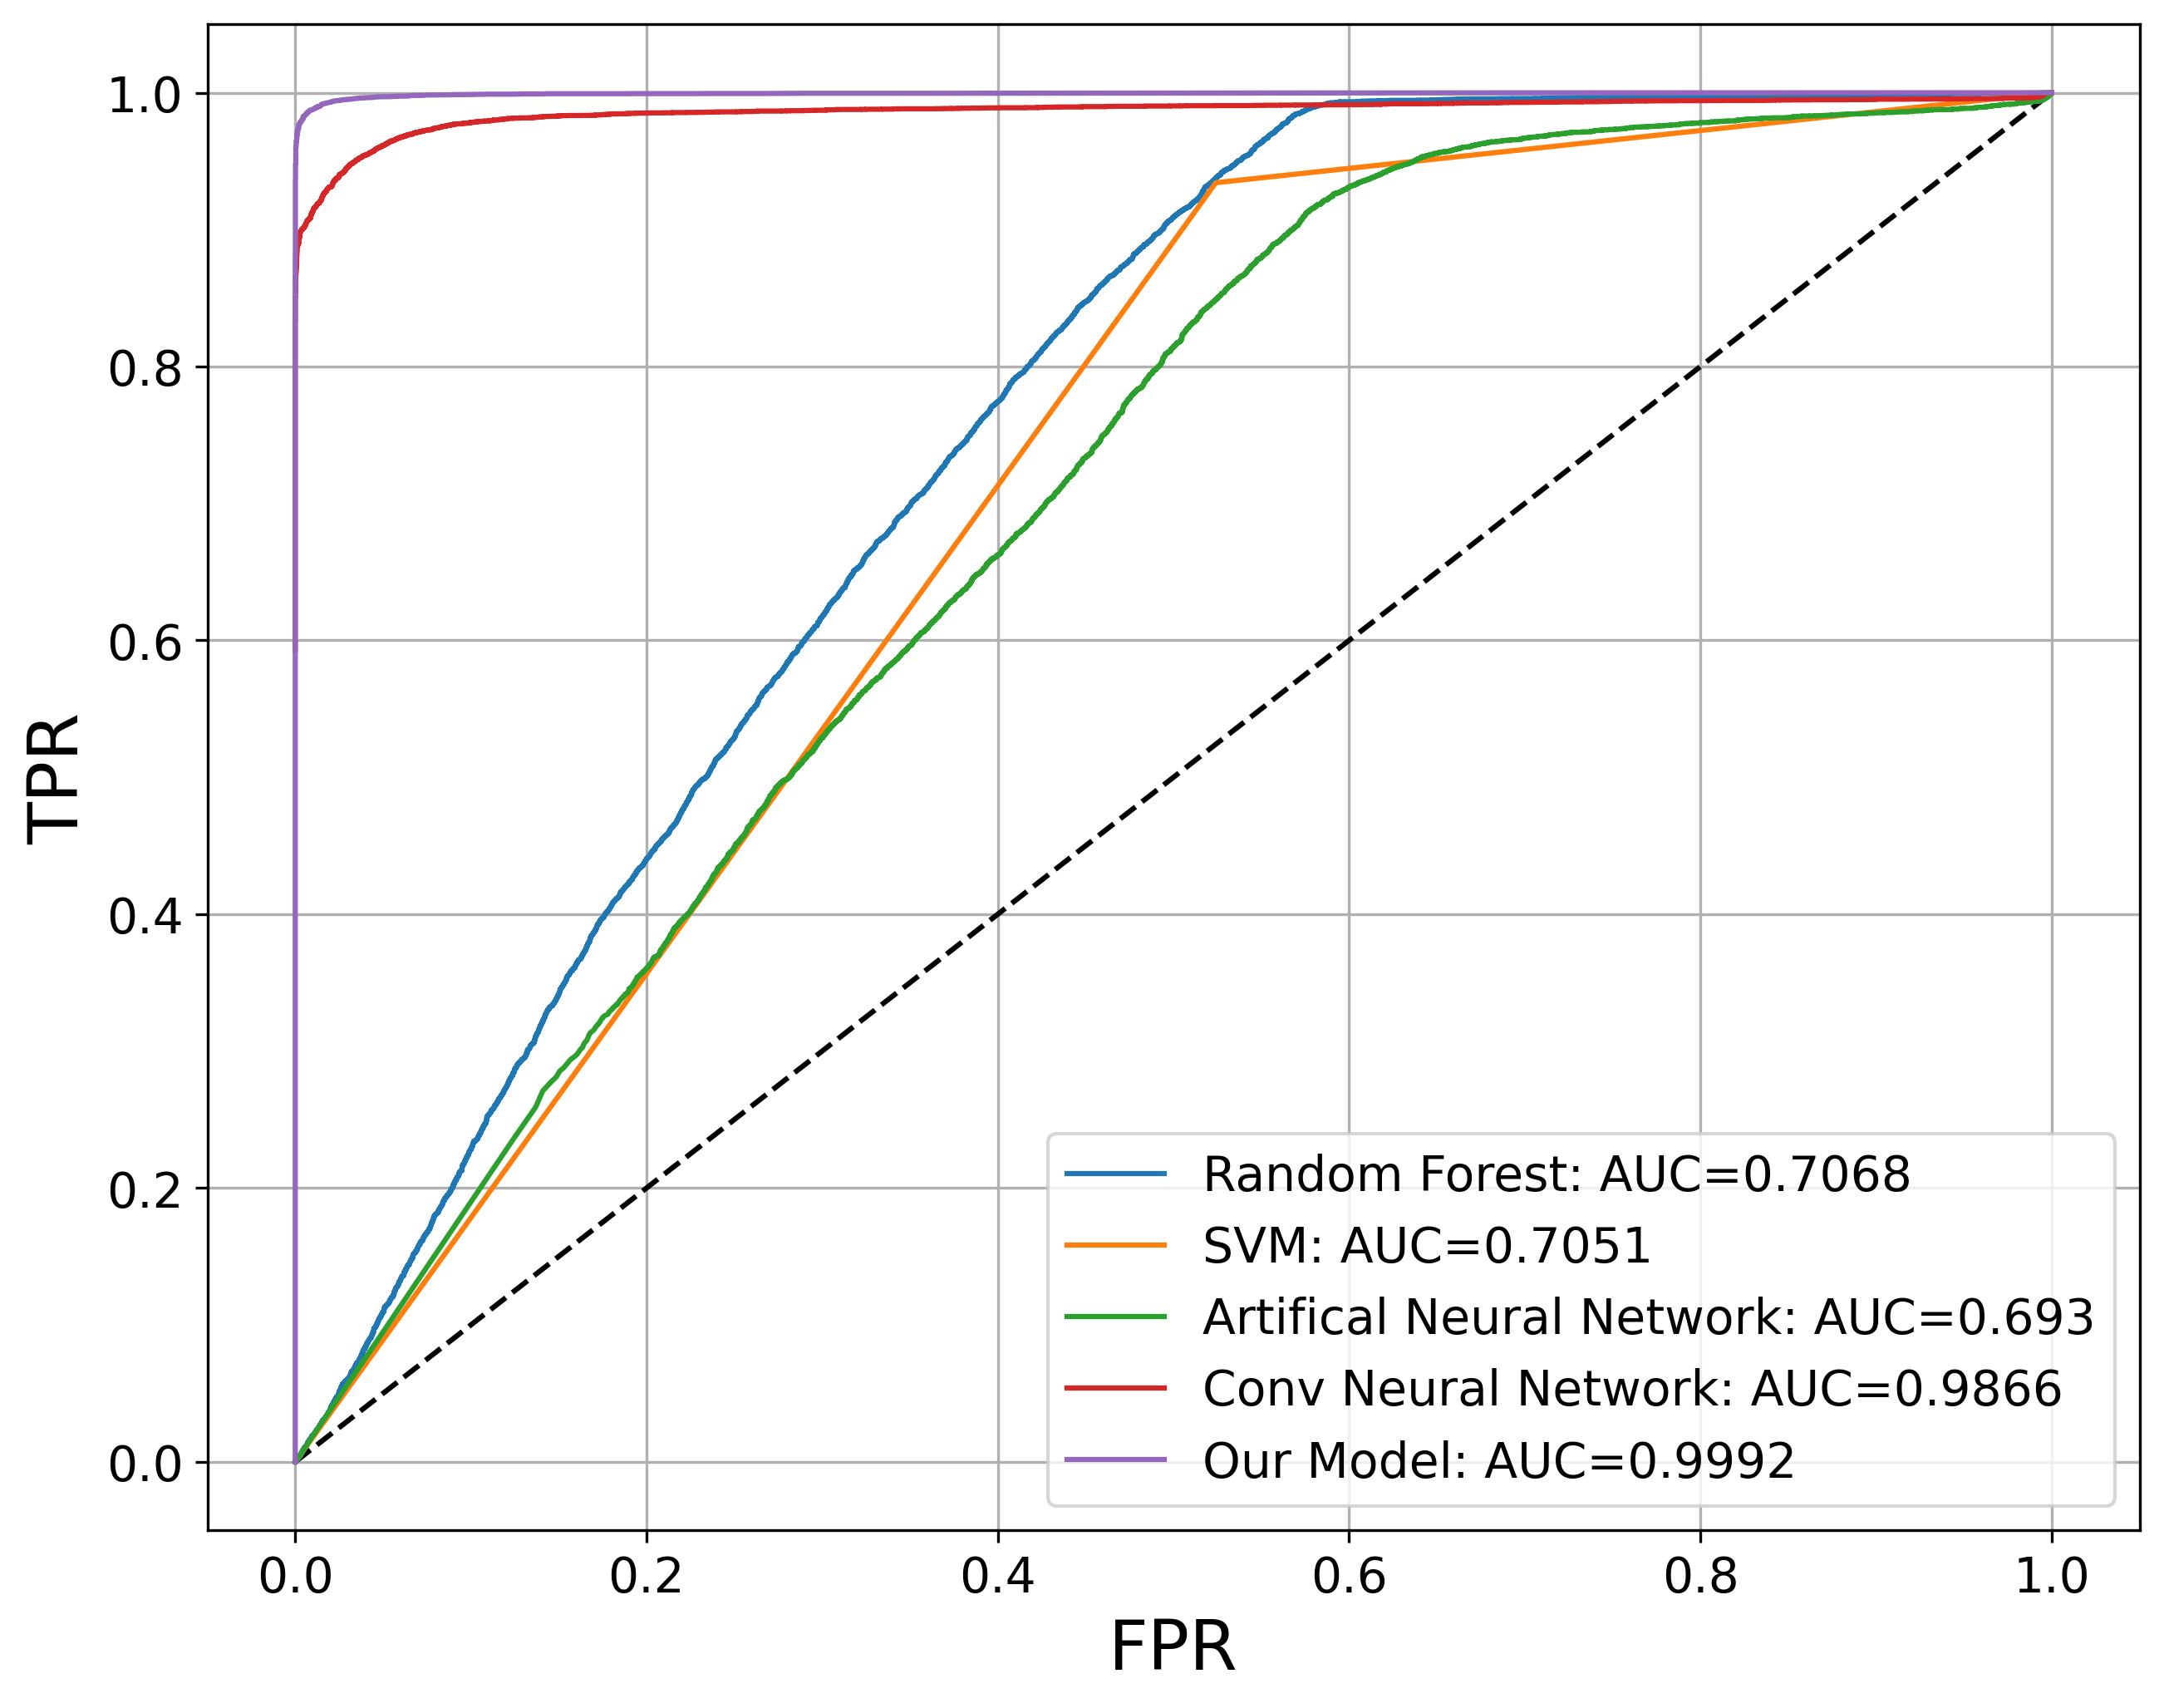

In [52]:
%matplotlib inline

fig = plt.figure(figsize=(10, 8), dpi=300)
plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr_tree, tpr_tree, label= "Random Forest: AUC="+str(round(auc_rf,4)))
plt.plot(fpr_svm, tpr_svm, label= "SVM: AUC="+str(round(auc_svm,4)))
plt.plot(fpr_ann, tpr_ann, label= "Artifical Neural Network: AUC="+str(round(auc_ann,4)))
plt.plot(fpr_cnn, tpr_cnn, label= "Conv Neural Network: AUC="+str(round(auc_conv,4)))
plt.plot(fpr_002, tpr_002, label= "Our Model: AUC="+str(round(auc_002,4)))         
plt.legend(fontsize=14)
plt.xlabel("FPR", fontsize=20)
plt.ylabel("TPR", fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.show()
fig.savefig('ROC_curve_update_params.pdf', format ='pdf')

# Out of Sample Signals

In [53]:
import matplotlib.pyplot as plt
from skimage import draw
from random import random 

In [54]:
def draw_shape():
    RADIUS_H = int(random()*6)+2
    RADIUS_W = int(random()*10)+1
    inital_H = int(random()*16)
    inital_W = int(random()*256)+126
    arr = np.zeros((6, 16, 512))
    
    drift_H = 0
    drift_W = 10
    
    rr, cc = draw.ellipse(inital_H, inital_W, RADIUS_H, RADIUS_W, shape=(16,512))
    arr[0, rr, cc] = 0.5
    
    
    rr, cc = draw.ellipse(inital_H+drift_H , inital_W+drift_W, RADIUS_H, RADIUS_W, shape=(16,512))
    arr[2, rr, cc] = 0.5
    
    
    rr, cc = draw.ellipse(inital_H+2*drift_H, inital_W+2*drift_W, RADIUS_H, RADIUS_W, shape=(16,512))
    arr[4, rr, cc] = 0.5
    
    return arr

In [55]:
mask =np.zeros(false_data_test.shape)
for i in range(false_data_test.shape[0]):
    mask[i, :,:,:,0]=false_data_test[i, :,:,:,0] + draw_shape()

In [56]:
test_out = np.concatenate((mask, false_data_test))
print(test_out.shape)
true_test_labels = np.ones((mask.shape[0]))

false_test_labels = np.zeros((false_data_test.shape[0]))
false_test_labels[:]=0
test_labels = np.concatenate((true_test_labels,false_test_labels))
print(test_labels.shape)
test_out, test_labels = shuffle(test_out, test_labels)

(24000, 6, 16, 512, 1)
(24000,)


In [57]:
mask =np.zeros(false_data_train.shape)
for i in range(false_data_train.shape[0]):
    mask[i, :,:,:,0]=false_data_train[i, :,:,:,0] + draw_shape()
mask[1, :,:,:,0] = mask[1, :,:,:,0]
plot_cadence(mask[0, :,:,:,0])

NameError: name 'plot_cadence' is not defined

In [ ]:
print(false_data_test[1, 0,:,:,0].min())
print(false_data_test[1, 1,:,:,0].min())
print(data.min())

# Outsample Conv Net

In [ ]:
from sklearn import metrics

fpr_cnn_out, tpr_cnn_out, _ = metrics.roc_curve(test_labels,   model_conv.predict(test_out))
auc_conv_out = metrics.roc_auc_score(test_labels,   model_conv.predict(test_out))
print(auc_conv_out)

# Outsample 002 Algorithm

In [ ]:
import joblib
from execute_model import model_load

model_name = "../test_bench/VAE-BLPC1-ENCODER_compressed_512v13-0"
zeroTwo = model_load(model_name+".h5")
forest = joblib.load('../test_bench/random_forest_1000_v4.joblib')

In [ ]:
frame_list = []
for i in range(test.shape[0]):
    print(i)
    frame_list.append(zeroTwo.predict(test_out[i,:,:,:,:])[2].ravel())
frame_list = np.array(frame_list)
probs_list = forest.predict_proba(frame_list)[:, 1]
print(probs_list)

In [ ]:
fpr_002_out, tpr_002_out, _ = metrics.roc_curve(test_labels,  probs_list)
auc_002_out= metrics.roc_auc_score(test_labels, probs_list)
print(auc_002_out)

# ROC Outsample

In [ ]:
%matplotlib inline

plt.figure(figsize=(10, 8), dpi=80)
plt.plot([0,1],[0,1], 'k--')

plt.plot(fpr_cnn_out, tpr_cnn_out, label= "Conv Neural Network: AUC="+str(round(auc_conv_out,4)))
plt.plot(fpr_002_out, tpr_002_out, label= "Our Model: AUC="+str(round(auc_002_out,4)))         
plt.legend(fontsize=14)
plt.xlabel("FPR", fontsize=20)
plt.ylabel("TPR", fontsize=20)
plt.grid()
plt.show()

In [ ]:
%matplotlib inline
def plot_cadence(data):
    fig, ax = plt.subplots(6, 1, figsize=(10,10))
    fig.subplots_adjust(hspace = .05, wspace=.001)
    for i in range(6):
        ax[i].imshow(data[i,:,:], CMAP='hot',aspect=3, vmin = data.min(), vmax = data.max())
#         ax[i].set_ylabel('Time Bins [18s]', fontsize=23)
        if i==5:
            ax[i].set_xlabel('Frequency [23.78Hz]', fontsize=20)
    fig.text(0.06, 0.5, 'Time [18.7s]', ha='center', va='center', rotation='vertical',  fontsize=16)
    plt.show()

plot_cadence(mask[1, :,:,:,0])